In [1]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import gc

edge_difffile = "G:/Hangkai/Forest_edge_mapping_data/Global_001_degree/2020Edge_2000Edge_diff.tif"
area_difffile = "G:/Hangkai/Forest_edge_mapping_data/Global_001_degree/2020Area_2000Area_diff.tif"


with rasterio.open(area_difffile) as src:
    area_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs

    # Mask out no-data values if necessary
    nodata = src.nodata
    if nodata is not None:
        area_data = np.ma.masked_equal(area_data, nodata)
    area_data = np.ma.masked_equal(area_data, 0)
    area_data = area_data/(1000*1000)
    
with rasterio.open(edge_difffile) as src:
    edge_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs
    
    # Mask out no-data values if necessary
    nodata = src.nodata
    if nodata is not None:
        edge_data = np.ma.masked_equal(edge_data, nodata)
    edge_data = np.ma.masked_equal(edge_data, 0)
    edge_data = edge_data/1000

del src
gc.collect()

area_lower = np.percentile(area_data.compressed(), 1)
area_upper = -1 * area_lower

edge_lower = np.percentile(edge_data.compressed(), 1)
edge_upper = -1 * edge_lower

In [2]:
print(area_lower)
print(area_upper)
print(edge_lower)
print(edge_upper)

-0.550287
0.550287
-8.07800006866455
8.07800006866455


In [2]:
area_lower = -0.1
area_upper = 0.1
edge_lower = -2
edge_upper = 2

print(area_lower)
print(area_upper)
print(edge_lower)
print(edge_upper)

mask = (area_data >= area_lower) & (area_data <= area_upper) & (edge_data >= edge_lower) & (edge_data <= edge_upper)
area_data[area_data < area_lower] = area_lower
area_data[area_data > area_upper] = area_upper
edge_data[edge_data < edge_lower] = edge_lower
edge_data[edge_data > edge_upper] = edge_upper

print(np.nanmax(edge_data))
print(np.nanmin(edge_data))
print(np.nanmax(area_data))
print(np.nanmin(area_data))

area_diff_clipped = np.clip(area_data, area_lower, area_upper)
edge_diff_clipped = np.clip(edge_data, edge_lower, edge_upper)

del area_data, edge_data,
gc.collect()

area_diff_norm = (area_diff_clipped + area_upper) / (2*area_upper)
del area_diff_clipped
gc.collect()

edge_diff_norm = (edge_diff_clipped + edge_upper) / (2*edge_upper)

del edge_diff_clipped
gc.collect()

# Compute the indices for your colormap
n = 40  # Number of steps (same as before)
area_indices = (area_diff_norm * (n - 1)).astype(int)
del area_diff_norm
gc.collect()
edge_indices = (edge_diff_norm * (n - 1)).astype(int)
del edge_diff_norm
gc.collect()

-0.1
0.1
-2
2
2.0
-2.0
0.1
-0.1


0

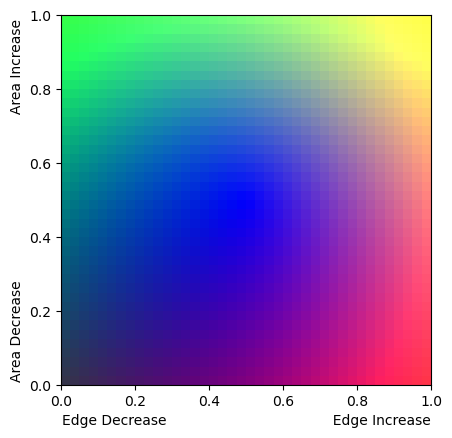

100%|████████████████████████████████████████████████████████████████████████████| 14000/14000 [22:55<00:00, 10.18it/s]

[-180.0, 180.0, -60.0, 80.0]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
def custom_colormap(i, j, n):
    # Normalize the indices to the range [0, 1]
    x = i / (n - 1)
    y = j / (n - 1)
    
    # Compute the distance from the center
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    
    # Define the color components based on distance from center
    g = np.clip(distance + (x - 0.5), 0, 1)
    r = np.clip(distance + (y - 0.5), 0, 1)
    b = np.clip(1 - distance, 0, 1)
    
    return (r, g, b, 1)

# Create an array representing the custom colormap
bivariate_colors = np.empty((n, n, 4))  # Initialize an empty array to store RGBA values

# Loop over each position in the array
for i in range(n):
    for j in range(n):
        bivariate_colors[i, j] = custom_colormap(i, j, n)

# Display the bivariate color scheme
plt.imshow(bivariate_colors, origin='lower', extent=[0, 1, 0, 1])
plt.xlabel('Edge Decrease                                      Edge Increase')
plt.ylabel('Area Decrease                                      Area Increase')
plt.show()


# Create an empty array to store the RGB values
color_array = np.zeros((*edge_indices.shape, 4))

# Assign colors from your custom colormap
for x in tqdm(range(edge_indices.shape[0])):
    for y in range(edge_indices.shape[1]):
        if mask[x, y]:
            i = area_indices[x, y]
            j = edge_indices[x, y]
            color_array[x, y] = bivariate_colors[i, j]
        else:
            color_array[x, y] = [1.0,1.0,1.0,1.0]

left, bottom = transform * (0, edge_indices.shape[0])
right, top = transform * (edge_indices.shape[1], 0)

extent = [left, right, bottom, top]
print(extent)

In [4]:
left, bottom = transform * (0, edge_indices.shape[0])
right, top = transform * (edge_indices.shape[1], 0)

extent = [left, right, bottom, top]
print(extent)

[-180.0, 180.0, -60.0, 80.0]


In [5]:
import rasterio
from rasterio.transform import from_origin

# Update the transformation to account for the number of bands (color channels)
transform = from_origin(transform[2], transform[5], transform[0], transform[4])

color_array_file = 'G:/Hangkai/Global forest edge/001degree/absolute_color_array_01_2.tif'

# Save color_array as a TIFF file
with rasterio.open(
    color_array_file,
    'w',
    driver='GTiff',
    height=color_array.shape[0],
    width=color_array.shape[1],
    count=4,  # color_array has 4 bands (RGBA)
    dtype=color_array.dtype,
    crs=crs,
    transform=transform
) as dst:
    for k in range(color_array.shape[2]):
        dst.write(color_array[:, :, k], k + 1)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import rasterio
import gc


color_array_file = 'G:/Hangkai/Global forest edge/001degree/absolute_color_array_01_2.tif'

with rasterio.open(color_array_file) as src:
    color_array_float32 = np.stack((src.read(1), src.read(2), src.read(3), src.read(4)), axis=-1, dtype=np.float32)
gc.collect()


6

Start to plot
Almost finished


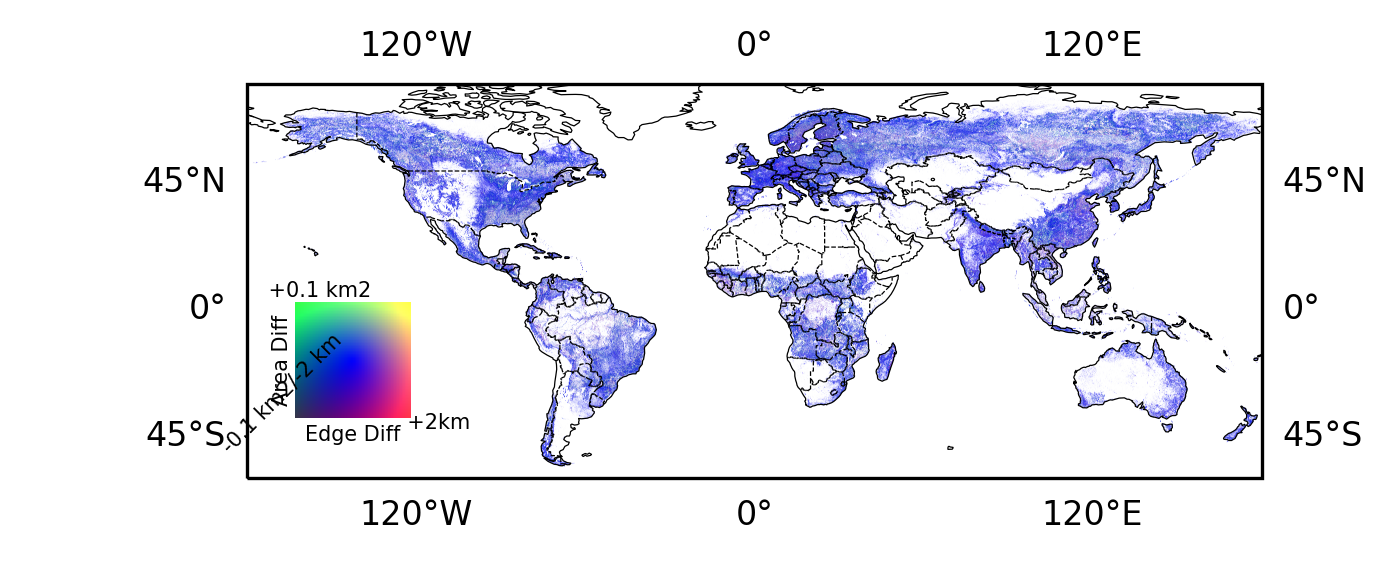

In [2]:
n = 40
def custom_colormap(i, j, n):
    # Normalize the indices to the range [0, 1]
    x = i / (n - 1)
    y = j / (n - 1)
    
    # Compute the distance from the center
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    
    # Define the color components based on distance from center
    g = np.clip(distance + (x - 0.5), 0, 1)
    r = np.clip(distance + (y - 0.5), 0, 1)
    b = np.clip(1 - distance, 0, 1)
    
    return (r, g, b, 1)

# Create an array representing the custom colormap
bivariate_colors = np.empty((n, n, 4))  # Initialize an empty array to store RGBA values

# Loop over each position in the array
for i in range(n):
    for j in range(n):
        bivariate_colors[i, j] = custom_colormap(i, j, n)
        
extent = [-180.0, 180.0, -60.0, 80.0]
plt.figure(dpi=300)

print("Start to plot")

# Create a GridSpec object
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

#
ax_map = plt.subplot(gs[0], projection=ccrs.PlateCarree())
ax_map.imshow(color_array_float32, extent=extent, transform=ccrs.PlateCarree())

print("Almost finished")

ax_map.coastlines(linewidth=0.3)
# ax_map.set_title('Edge Dynamic', fontsize=10)
ax_map.tick_params(labelsize=15)
gl = ax_map.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
                      linewidth=0, color='gray', alpha=0.5, 
                      xlocs=[-120, 0, 120],  # Adjust for desired longitude spacing
                      ylocs=[-90, -45, 0, 45, 90])
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')

ax_map.add_feature(countries, edgecolor='black', linestyle='--', linewidth = 0.3)

labels = gl.xlabel_style
labels['size'] = 8  # Change to desired size.
gl.xlabel_style = labels
labels = gl.ylabel_style
labels['size'] = 8  # Change to desired size.
gl.ylabel_style = labels

# Create Axes objects for color mapping
cmap_position = [0.14, 0.4, 0.08, 0.08]  # Adjust these values to position ax_cmap as desired

ax_cmap = plt.gcf().add_axes(cmap_position)
cmap_image = ax_cmap.imshow(bivariate_colors, origin='lower', extent=[0, 1, 0, 1])

camp_font_size = 5
ax_cmap.axis('off')
ax_cmap.text(0.5, -0.3, '-0.1 km2/-2 km                              ',
             fontsize=camp_font_size, ha='center', transform=ax_cmap.transAxes, rotation=45)
ax_cmap.text(0.5, -0.2, 'Edge Diff', fontsize=camp_font_size, ha='center', transform=ax_cmap.transAxes)
ax_cmap.text(0.5, -0.1, '                          +2km', fontsize=camp_font_size, ha='center',
             transform=ax_cmap.transAxes)
ax_cmap.text(-2.3, 1.1, '                                    +0.1 km2', fontsize=camp_font_size, va='center',
            transform=ax_cmap.transAxes)
ax_cmap.text(-0.2, 0.5, 'Area Diff', fontsize=camp_font_size, va='center', rotation='vertical', transform=ax_cmap.transAxes)

# plt.show()
plt.savefig('output_01_2.tif', format='tiff', dpi=600)

In [6]:
import rasterio

# 替换为你的地理空间TIFF文件路径
file_path = 'G:/Hangkai/CONUS Forest Edge Mapping/CONUS Landcover/2001LC.tif'

with rasterio.open(file_path) as src:
    # 获取数据类型而不实际读取数据
    data_type = src.dtypes[0]  # 获取第一个波段的数据类型

print(f"The data type of the landcover map is: {data_type}")


The data type of the landcover map is: int16
